<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/S12/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Colab and importing generic Packages
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import torchvision
import torch
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,Cutout)
print(os.getcwd())
drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks\resnet')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/resnet')


/content
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#importing self-created packages:
import test_train1 as t                                                         #import train - test module .This is class to train and evaluate the model
import load as ld                                                               #dataloader
import mod_summ as m                                                            #Getting model summary package
import Imagenet_Basic_Block as bb                                                        #Getting Classes for Resnet and Basic Block
import albumm as al                                                            #Getting albumentation module
import override_album as oa                                                     # overriding the albumentation class
import GradCm as gd                                                             #Grad Cam Module
import plot_cam   as pt                                                         #Plotting Image with Gradcam
import lr_update  as lr                                                         #exponential LR update


In [0]:
# RESNET BLOCK
 def ResNet18():
  return bb.ResNet(bb.BasicBlock, [2,2,2,2])
def test():  
  net = ResNet18()
  y = net(torch.randn(1,3,64,64))
  return net

In [4]:
net=test().to('cuda')   
#net=test().to('cpu')
#net=test()
#net=test()#Net - Model to CUDA 
m.summ_print(net,(3,64,64))# Model summary.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [5]:
#!unzip tiny-imagenet-200.zip -d '/content/gdrive/My Drive/Colab Notebooks/resnet/imagenet'
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 4.63 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


In [0]:
val_dir = './IMagenet/tiny-imagenet-200/train'
val_dataset = datasets.ImageFolder(root=val_dir)

In [7]:
print(len(val_dataset))
trainset, testset = torch.utils.data.random_split(val_dataset, [70000, 30000])
trainset1, testset1 = torch.utils.data.random_split(val_dataset, [70000, 30000])

100000


In [0]:
train_transforms,test_transforms=al.album_transform(albumentations)             #Albumentation class 

In [0]:
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                        download=True, transform=None)        
#                                      
#testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                       download=True, transform=None)

In [0]:
# Initialize the dataset, pass the augmentation pipeline as an argument to init function
train_ds = oa.PyTorchImageDataset(image=trainset, augmentations=train_transforms)
test_ds =  oa.PyTorchImageDataset(image=testset, augmentations=test_transforms)           

In [0]:
batch_size=256
trainloader,testloader=ld.load_test_train(batch_size,train_ds,test_ds,torchvision,torch)

In [0]:
def range_test(end_lr=10,num_iter=100,step_mode="exp", smooth_f=0.05, diverge_th=5):
        if step_mode.lower() == "exp":
            lr_schedule = lr.ExponentialLR(optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":         
            lr_schedule = lr.LinearLR(optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")
        return lr_schedule

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
optimizer = optim.SGD(net.parameters(),lr=0.0000000001)                           # start LR is 0.0001
criterion=nn.CrossEntropyLoss()
lr_schedule=range_test(end_lr=10,num_iter=100,step_mode="exp",smooth_f=0.04,diverge_th=5)
best_loss = None
diverge_th=50
num_iter=100
smooth_f=0.05
#scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
#optimizer=optim.Adam(model.parameters(), lr=0.045, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
device='cuda'
#device='cpu'
best_lr,best_loss,history=t.train(net, device, trainloader,lr_schedule,optimizer,train_losses,train_acc,tqdm,criterion,smooth_f,diverge_th)

 81%|████████  | 111/137 [04:21<00:59,  2.29s/it]

Stopping early, the loss has diverged


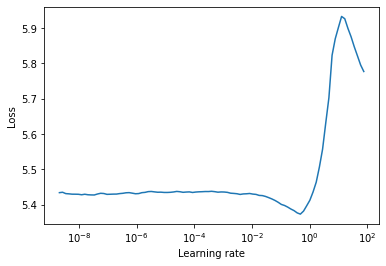

In [0]:
import plot_lr as pltr
ax=pltr.plot(history,plt) 
ax # PLot the LR graph       

In [0]:
print("The best learning rate obtained is ",best_lr)

The best learning rate obtained is  0.4786300923226384


In [0]:
net1=test().to('cuda')   

In [11]:
import train_test_model_resnet18_missclass as t1   #import train - test module .This is class to train and evaluate the model
import numpy as np                                
train_losses = []
best_lr=0.047
test_acc = []
test_losses = []
train_acc = []
train_loss_graph=[]
train_acc_graph=[]
test_acc_graph=[]
test_loss_graph=[]
optimizer = optim.SGD(net.parameters(),lr=best_lr,weight_decay=0.0015,momentum=0.90)
criterion=nn.CrossEntropyLoss()
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,patience=3,min_lr=0.000001)
#scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
#optimizer=optim.Adam(model.parameters(), lr=0.045, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
EPOCHS = 50
device='cuda'
#device='cpu'
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_loss,train_acc1=t1.train(net, device, trainloader, optimizer, epoch,train_losses,train_acc,tqdm,criterion)
    train_loss_graph.append(train_loss)
    train_acc_graph.append(train_acc1)
    test_loss,test_acc1=t1.test(net, device, testloader,test_losses,test_acc,tqdm,criterion,torch)
    test_loss_graph.append(test_loss)
    test_acc_graph.append(test_acc1)
    scheduler.step(test_loss)
      

  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 0


Loss=4.231062412261963 Batch_id=273 Accuracy=5.30: 100%|██████████| 274/274 [02:39<00:00,  1.72it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 1440/30000 (4.80%)

EPOCH: 1


Loss=4.112504005432129 Batch_id=273 Accuracy=10.37: 100%|██████████| 274/274 [02:35<00:00,  1.76it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 2301/30000 (7.67%)

EPOCH: 2


Loss=3.8533778190612793 Batch_id=273 Accuracy=14.58: 100%|██████████| 274/274 [02:37<00:00,  1.74it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 3225/30000 (10.75%)

EPOCH: 3


Loss=3.537308931350708 Batch_id=273 Accuracy=17.94: 100%|██████████| 274/274 [02:36<00:00,  1.75it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 4384/30000 (14.61%)

EPOCH: 4


Loss=3.498675584793091 Batch_id=273 Accuracy=21.13: 100%|██████████| 274/274 [02:38<00:00,  1.73it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 4365/30000 (14.55%)

EPOCH: 5


Loss=3.340824604034424 Batch_id=273 Accuracy=23.90: 100%|██████████| 274/274 [02:35<00:00,  1.76it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 5478/30000 (18.26%)

EPOCH: 6


Loss=2.9742681980133057 Batch_id=273 Accuracy=26.47: 100%|██████████| 274/274 [02:37<00:00,  1.74it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 4913/30000 (16.38%)

EPOCH: 7


Loss=2.903977632522583 Batch_id=273 Accuracy=28.56: 100%|██████████| 274/274 [02:38<00:00,  1.73it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 6538/30000 (21.79%)

EPOCH: 8


Loss=2.7777552604675293 Batch_id=273 Accuracy=30.60: 100%|██████████| 274/274 [02:41<00:00,  1.70it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0130, Accuracy: 6984/30000 (23.28%)

EPOCH: 9


Loss=2.7588424682617188 Batch_id=273 Accuracy=32.39: 100%|██████████| 274/274 [02:37<00:00,  1.74it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 6264/30000 (20.88%)

EPOCH: 10


Loss=2.736609935760498 Batch_id=273 Accuracy=33.58: 100%|██████████| 274/274 [02:38<00:00,  1.73it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 8044/30000 (26.81%)

EPOCH: 11


Loss=2.8103795051574707 Batch_id=273 Accuracy=35.52: 100%|██████████| 274/274 [02:38<00:00,  1.73it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 7120/30000 (23.73%)

EPOCH: 12


Loss=2.7887494564056396 Batch_id=273 Accuracy=36.39: 100%|██████████| 274/274 [02:40<00:00,  1.71it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 5536/30000 (18.45%)

EPOCH: 13


Loss=2.465176820755005 Batch_id=273 Accuracy=37.07: 100%|██████████| 274/274 [02:41<00:00,  1.70it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 8045/30000 (26.82%)

EPOCH: 14


Loss=2.6445605754852295 Batch_id=273 Accuracy=38.16: 100%|██████████| 274/274 [02:37<00:00,  1.74it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0130, Accuracy: 7648/30000 (25.49%)

EPOCH: 15


Loss=2.516371488571167 Batch_id=273 Accuracy=38.82: 100%|██████████| 274/274 [02:39<00:00,  1.72it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 7852/30000 (26.17%)

EPOCH: 16


Loss=2.5555806159973145 Batch_id=273 Accuracy=39.75: 100%|██████████| 274/274 [02:46<00:00,  1.64it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 8568/30000 (28.56%)

EPOCH: 17


Loss=2.631164789199829 Batch_id=273 Accuracy=40.46: 100%|██████████| 274/274 [02:38<00:00,  1.73it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 9307/30000 (31.02%)

EPOCH: 18


Loss=2.2071120738983154 Batch_id=273 Accuracy=41.03: 100%|██████████| 274/274 [02:36<00:00,  1.75it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 8698/30000 (28.99%)

EPOCH: 19


Loss=2.26932954788208 Batch_id=273 Accuracy=41.82: 100%|██████████| 274/274 [02:37<00:00,  1.74it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 9476/30000 (31.59%)

EPOCH: 20


Loss=2.537421464920044 Batch_id=273 Accuracy=42.07: 100%|██████████| 274/274 [02:36<00:00,  1.75it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0131, Accuracy: 7509/30000 (25.03%)

EPOCH: 21


Loss=2.5150907039642334 Batch_id=273 Accuracy=42.59: 100%|██████████| 274/274 [02:35<00:00,  1.76it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 8045/30000 (26.82%)

EPOCH: 22


Loss=1.9110300540924072 Batch_id=273 Accuracy=53.57: 100%|██████████| 274/274 [02:34<00:00,  1.77it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 12919/30000 (43.06%)

EPOCH: 23


Loss=1.800836205482483 Batch_id=273 Accuracy=56.88: 100%|██████████| 274/274 [02:35<00:00,  1.77it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 12870/30000 (42.90%)

EPOCH: 24


Loss=1.950374722480774 Batch_id=273 Accuracy=58.47: 100%|██████████| 274/274 [02:33<00:00,  1.79it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 12981/30000 (43.27%)

EPOCH: 25


Loss=1.5618950128555298 Batch_id=273 Accuracy=59.61: 100%|██████████| 274/274 [02:32<00:00,  1.80it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 13580/30000 (45.27%)

EPOCH: 26


Loss=1.5450752973556519 Batch_id=273 Accuracy=60.58: 100%|██████████| 274/274 [02:29<00:00,  1.83it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 13085/30000 (43.62%)

EPOCH: 27


Loss=1.8448231220245361 Batch_id=273 Accuracy=61.64: 100%|██████████| 274/274 [02:35<00:00,  1.76it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 13440/30000 (44.80%)

EPOCH: 28


Loss=1.4038597345352173 Batch_id=273 Accuracy=62.21: 100%|██████████| 274/274 [02:34<00:00,  1.77it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 13058/30000 (43.53%)

EPOCH: 29


Loss=1.6840556859970093 Batch_id=273 Accuracy=63.23: 100%|██████████| 274/274 [02:34<00:00,  1.77it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 12758/30000 (42.53%)

EPOCH: 30


Loss=1.4786179065704346 Batch_id=273 Accuracy=66.51: 100%|██████████| 274/274 [02:33<00:00,  1.78it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 13519/30000 (45.06%)

EPOCH: 31


Loss=1.1398762464523315 Batch_id=273 Accuracy=67.32: 100%|██████████| 274/274 [02:34<00:00,  1.77it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 13629/30000 (45.43%)

EPOCH: 32


Loss=1.4946361780166626 Batch_id=273 Accuracy=67.68: 100%|██████████| 274/274 [02:36<00:00,  1.75it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 13465/30000 (44.88%)

EPOCH: 33


Loss=1.4101955890655518 Batch_id=273 Accuracy=68.04: 100%|██████████| 274/274 [02:33<00:00,  1.78it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 13720/30000 (45.73%)

EPOCH: 34


Loss=1.1319758892059326 Batch_id=273 Accuracy=68.20: 100%|██████████| 274/274 [02:35<00:00,  1.76it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 13533/30000 (45.11%)

EPOCH: 35


Loss=1.2510954141616821 Batch_id=273 Accuracy=68.30: 100%|██████████| 274/274 [02:36<00:00,  1.76it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 13543/30000 (45.14%)

EPOCH: 36


Loss=1.3815869092941284 Batch_id=273 Accuracy=68.49: 100%|██████████| 274/274 [02:35<00:00,  1.76it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 13508/30000 (45.03%)

EPOCH: 37


Loss=1.3627188205718994 Batch_id=273 Accuracy=68.82: 100%|██████████| 274/274 [02:36<00:00,  1.75it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 13514/30000 (45.05%)

EPOCH: 38


Loss=1.2026795148849487 Batch_id=273 Accuracy=69.30: 100%|██████████| 274/274 [02:35<00:00,  1.76it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 13461/30000 (44.87%)

EPOCH: 39


Loss=1.61204993724823 Batch_id=273 Accuracy=69.43: 100%|██████████| 274/274 [02:31<00:00,  1.81it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 13507/30000 (45.02%)

EPOCH: 40


Loss=1.4007335901260376 Batch_id=273 Accuracy=69.43: 100%|██████████| 274/274 [02:34<00:00,  1.78it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 13539/30000 (45.13%)

EPOCH: 41


Loss=1.438993215560913 Batch_id=273 Accuracy=69.49: 100%|██████████| 274/274 [02:44<00:00,  1.67it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 13470/30000 (44.90%)

EPOCH: 42


Loss=1.2556031942367554 Batch_id=273 Accuracy=69.52: 100%|██████████| 274/274 [02:33<00:00,  1.79it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 13445/30000 (44.82%)

EPOCH: 43


Loss=1.3037437200546265 Batch_id=273 Accuracy=69.53: 100%|██████████| 274/274 [02:34<00:00,  1.77it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 13478/30000 (44.93%)

EPOCH: 44


Loss=1.443287968635559 Batch_id=273 Accuracy=69.56: 100%|██████████| 274/274 [02:34<00:00,  1.78it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 13443/30000 (44.81%)

EPOCH: 45


Loss=1.1419517993927002 Batch_id=273 Accuracy=69.61: 100%|██████████| 274/274 [02:35<00:00,  1.76it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 13462/30000 (44.87%)

EPOCH: 46


Loss=1.3342196941375732 Batch_id=273 Accuracy=69.57: 100%|██████████| 274/274 [02:37<00:00,  1.74it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 13530/30000 (45.10%)

EPOCH: 47


Loss=1.303945541381836 Batch_id=273 Accuracy=69.60: 100%|██████████| 274/274 [02:35<00:00,  1.77it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 13359/30000 (44.53%)

EPOCH: 48


Loss=1.4828426837921143 Batch_id=273 Accuracy=69.67: 100%|██████████| 274/274 [02:36<00:00,  1.75it/s]
  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 13617/30000 (45.39%)

EPOCH: 49


Loss=1.449647307395935 Batch_id=273 Accuracy=69.51: 100%|██████████| 274/274 [02:36<00:00,  1.75it/s]



Test set: Average loss: 0.0090, Accuracy: 13556/30000 (45.19%)



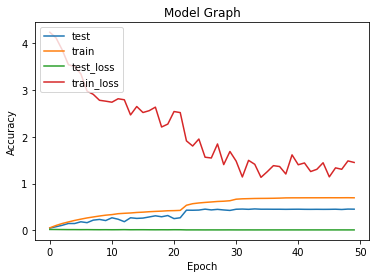

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(test_acc_graph)                
plt.plot(train_acc_graph)
plt.plot(test_loss_graph)    
plt.plot(train_loss_graph)       
plt.title("Model Graph")          
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')               
plt.legend(['test','train','test_loss','train_loss'] ,loc='upper left')
plt.show()  
plt.savefig('Upload_graph.png')                                          

In [0]:
cam2=[]          
data2=[]
k=[]
dat=[]
number=0
p=[]
l=[]
data2=[]
for im in range(25):
  
  dat1,label = next(iter(testloader))
  dat1=dat1.to('cuda')
  output=net(dat1)
  pred = output.argmax(dim=1, keepdim=True)
  
  for i in range(label.size()[0]):
   if pred[i].item() != label[i].item():
    p.append(pred[i].item()) 
    l.append(label[i].item()) 
    label1=label[i]
    data1=dat1[i]
    data2.append(dat1[i].to('cpu'))
    label1=label1.unsqueeze(0) 
    Gd1=gd.GradCm()
    cam1=Gd1.img(data1,label1,net)
    cam2.append(cam1) 
    number = len(cam2)
    if number >= 25:
        print(number)
        break
  else:
   continue
  break 

In [0]:
plott=pt.Plot()
#l=l.to('cpu')
#data2=data2.to('cpu')
plott.fig(data2,cam2,l,p)
